## Import all necessary library 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import xverse


from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
# from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, plot_roc_curve, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

## Load all data 

In [2]:
master = pd.read_csv("./Customer_Information.csv")
master.tail()

,customer_id,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK
6583,43180,38,11000000.0,Female,Bachelor Degree,Working Capital,10:54:00,No,Yes,1
6584,43181,37,30000000.0,Female,Bachelor Degree,Education,07:04:00,No,Yes,1
6585,43182,50,16000000.0,Female,Master's Degree/Post graduate,Renovation,10:47:00,No,Yes,1
6586,43184,36,5000000.0,Male,Bachelor Degree,Other,15:49:00,No,Yes,1
6587,43185,37,40000000.0,Male,Bachelor Degree,Electronic unsecured loan,11:48:00,Yes,Yes,1


In [3]:
bureau = pd.read_csv("./Credit_Bureau_Data.csv")
bureau.head()

,customer_id,LOANS_WITHOUT_DELAYS,LOANS_WITH_DELAYS,KNOWN_ASSETS
0,36493,3,3,40000000.0
1,36494,3,0,20000000.0
2,36496,2,1,0.0
3,36497,1,0,40000000.0
4,36498,7,0,NaN


In [4]:
external = pd.read_csv("./External_Score.csv")
external.head()

,customer_id,Score
0,36493,0.77
1,36494,0.93
2,36496,0.78
3,36497,0.81
4,36498,0.78


## Train-test-validation split

We are going to do splitting and do all of our analysis on the training dataset only. But first we will combine all 3 datasets into one big dataset

In [5]:
# merge master and bureau and external data
df = pd.merge(master, bureau, on='customer_id', how='left')
df = pd.merge(df, external, on='customer_id', how='left')
df.head()

,customer_id,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK,LOANS_WITHOUT_DELAYS,LOANS_WITH_DELAYS,KNOWN_ASSETS,Score
0,36493,40,10000000.0,Female,Diploma,Working Capital,09:07:00,No,Yes,1,3.0,3.0,40000000.0,0.77
1,36494,39,15000000.0,Female,Bachelor Degree,Other,15:15:00,No,Yes,1,3.0,0.0,20000000.0,0.93
2,36495,28,15000000.0,Male,Bachelor Degree,Renovation,07:13:00,No,Yes,1,NaN,NaN,NaN,NaN
3,36496,28,4000000.0,Male,Bachelor Degree,Renovation,12:05:00,Yes,Yes,1,2.0,1.0,0.0,0.78
4,36497,38,10000000.0,Male,Diploma,Renovation,14:35:00,Yes,Yes,0,1.0,0.0,40000000.0,0.81


Then we are splitting into train and test. We will use 70 - 30 split for initial train - holdout(test) data split, and the same proportion for splitting intial train to train - validation dataset.
We are going to utilize codes in live classes to make the transformation job easier

In [6]:
import joblib

def split_input_output(dataset,
                       target_column,
                       save_file = True,
                       return_file = True):
    
    output_df = dataset[target_column]
    input_df = dataset.drop([target_column],
                            axis = 1)
    
    if save_file:
        joblib.dump(output_df, "output/output_df.pkl")
        joblib.dump(input_df, "output/input_df.pkl")
    
    if return_file:
        return output_df, input_df


def split_train_test(x, y, TEST_SIZE):
    # Do not forget to stratify if classification
    x_train, x_test,\
        y_train, y_test = train_test_split(x,
                                           y,
                                           test_size=TEST_SIZE,
                                           random_state=123,
                                          stratify=y)

    return x_train, x_test, y_train, y_test

def split_data(data_input, data_ouput, return_file=False, TEST_SIZE=0.2):

    x_train, x_test, \
        y_train, y_test = split_train_test(
            data_input,
            data_ouput,
            TEST_SIZE)

    x_train, x_valid, \
        y_train, y_valid = split_train_test(
            x_train,
            y_train,
            TEST_SIZE)

    joblib.dump(x_train, "output/x_train.pkl")
    joblib.dump(y_train, "output/y_train.pkl")
    joblib.dump(x_valid, "output/x_valid.pkl")
    joblib.dump(y_valid, "output/y_valid.pkl")
    joblib.dump(x_test, "output/x_test.pkl")
    joblib.dump(y_test, "output/y_test.pkl")

    if return_file:
        return x_train, y_train, \
            x_valid, y_valid, \
            x_test, y_test

In [7]:
# do the splitting
TARGET = "LOAN_WAS_PAID_BACK"
TEST_SIZE = 0.3

output_df, input_df = split_input_output(
                            df,
                            TARGET, save_file = False)

x_train, y_train, x_valid, y_valid, x_test, y_test = split_data(input_df,
                                                                    output_df,
                                                                   True,
                                                                   TEST_SIZE)

In [8]:
# check if stratify is correct
print(y_train.value_counts(normalize = True))
print("-------------------------------------")
print(y_valid.value_counts(normalize = True))
print("-------------------------------------")
print(y_test.value_counts(normalize = True))

1    0.853734
0    0.146266
Name: LOAN_WAS_PAID_BACK, dtype: float64
-------------------------------------
1    0.854046
0    0.145954
Name: LOAN_WAS_PAID_BACK, dtype: float64
-------------------------------------
1    0.853819
0    0.146181
Name: LOAN_WAS_PAID_BACK, dtype: float64


## Initial Data Exploration

For this initial exploration we are going to combine x_train and y_train into a single dataframe, to know how each feature corelate with the target variable

In [9]:
# combine x_train and y_train
df = pd.concat([x_train, pd.DataFrame(y_train)], axis = 1)

# check initial features
df.columns.values

array(['customer_id', 'AGE', 'INCOME', 'GENDER', 'EDUCATION',
       'LOAN_PURPOSE', 'APPLICATION_RECEIVE_TIME', 'HAS_APPLIED_BEFORE',
       'HAS_INCOME_VERIFICATION', 'LOANS_WITHOUT_DELAYS',
       'LOANS_WITH_DELAYS', 'KNOWN_ASSETS', 'Score', 'LOAN_WAS_PAID_BACK'],
      dtype=object)

Initial features explanation :
 - customer_id : unique identification number for each customer
 - age : customer's age
 - income : customer's monthly income in rupiah 
 - gender : customer's gender (male/female)
 - education : customer's last education level 
 - loan_purpose : why the customer apply for a loan
 - application_receive_time : the time (HH:MM:SS) of when the system receive customer's application
 - has_applied_before : binary feature which show whether customer's has previously submit an application (1) before the current on, regardless of being approved or not
 - has_income_verification : has customer provide additional data such as payslip or bank statement to get their income verified
 - loans_without_delays : count of all the customer's previous loan which has never been late in installment payments
 - loans_with_delays : count of all the customer's previous loan which has late installment payments
 - known_assets : amount of declared assets by customer (in rupiah)
 - score : external scoring done by third party 

### Comments on score feature

As it happen, score is an external, third party feature that quite possibly will introduce bias to the data. Since it is supposedly done after the loan was submitted and passed through to the 3rd party, therefore at application time the information will simply unavailable. 

Calon feature :
- Age (binning sendiri aja, yang ga masuk kriteria kita tolak (<17 tahun atau >55 ))
- Gender
- EDUCATION (SD SMP masuk other) -> dummy variable (one hot_encoding)
- Loan purpose yang kosong kita drop -> dummy variable (one hot_encoding)
- HAS_APPLIED_BEFORE
- HAS_INCOME_VERIFICATION

if have bureau tambah fitur dan pakai model 2:
- LOAN WITHOUT/WITH DELAYS (~di binning~ / numerical)

In [10]:
# checking data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3227 entries, 1749 to 1395
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               3227 non-null   int64  
 1   AGE                       3227 non-null   int64  
 2   INCOME                    3226 non-null   float64
 3   GENDER                    3227 non-null   object 
 4   EDUCATION                 3227 non-null   object 
 5   LOAN_PURPOSE              3202 non-null   object 
 6   APPLICATION_RECEIVE_TIME  3227 non-null   object 
 7   HAS_APPLIED_BEFORE        3227 non-null   object 
 8   HAS_INCOME_VERIFICATION   3227 non-null   object 
 9   LOANS_WITHOUT_DELAYS      2601 non-null   float64
 10  LOANS_WITH_DELAYS         2601 non-null   float64
 11  KNOWN_ASSETS              1918 non-null   float64
 12  Score                     2298 non-null   float64
 13  LOAN_WAS_PAID_BACK        3227 non-null   int64  
dtypes: fl

In [11]:
# check numerical features distribution
df.describe()

,customer_id,AGE,INCOME,LOANS_WITHOUT_DELAYS,LOANS_WITH_DELAYS,KNOWN_ASSETS,Score,LOAN_WAS_PAID_BACK
count,3227.000000,3227.000000,3.226000e+03,2601.000000,2601.00000,1.918000e+03,2298.000000,3227.000000
mean,39818.245739,34.391075,8.022319e+06,1.629758,0.39331,1.274765e+07,0.786749,0.853734
std,1924.671777,7.788081,6.526235e+06,0.811091,0.86350,1.280282e+07,0.083135,0.353427
min,36497.000000,20.000000,0.000000e+00,1.000000,0.00000,0.000000e+00,0.500000,0.000000
25%,38147.000000,28.000000,4.000000e+06,1.000000,0.00000,0.000000e+00,0.760000,1.000000
50%,39791.000000,33.000000,6.000000e+06,1.000000,0.00000,1.000000e+07,0.790000,1.000000
75%,41471.500000,40.000000,9.000000e+06,2.000000,0.00000,2.000000e+07,0.850000,1.000000
max,43185.000000,54.000000,7.000000e+07,6.000000,3.00000,5.000000e+07,0.950000,1.000000


### Notes on numerical data
- There are 3277 data out of 6587 total customers (~50%) in the training data
- Youngest applicant is at 20 years old, with oldest customer is at 54 years old, average age is around 34 years old. Side note : all loan applicants are required to have KTP as a mandatory documents, meaning that the legal minimum age of applying for a loan is 17 in Indonesia. However, since most people age 17 - 20 are in majority still studying and does not have any income, it is plausible that applicants on that age group are being denied a loan, hence the minimum age in the data. It is also common practice for banks or lending fintech to impose age requirements of 18 - 55, which might be the case in hand
- customer id only act as identifier even though it classified as numerical feature
- There are customers who input income as 0, which might be because of a typo or they don't have an income source.
- Loans with / without delays are bureau data, and they only cover about 80% of the total training data. This is possibly because the remaining customer are first time applicant and don't have their bureau data available, or possibly some error in fetching the bureau data
- Most customer  (>75%) no loans with delays in installment payment. 
- Only about 60% of the customer in the sample has disclosed their known_assets information, and more than 1/4 of them listed 0 
- Only one missing value in INCOME variable, which we may drop

In [12]:
# check on categorical features
df.describe(include=['O'])

,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION
count,3227,3227,3202,3227,3227,3227
unique,2,5,12,1096,2,2
top,Male,Bachelor Degree,Working Capital,10:35:00,No,Yes
freq,1727,1689,994,11,2062,3158


### Notes on numerical data
- Most feature does not have missing data, other than LOAN_PURPOSE which contains 25 rows of missing data
- Application receive time is varying between each customer and only serve as timestamp
- most applicant (52%) hold a bachelor's degree
- almost 1/3 (31%) of the customer apply for a Working Capital loan
- Almost all of the customer in the sample have had their income verified 

### Feature Engineering 

Based on all the data we have so far, we are going list some assumptions that might be helpful in selecting and engineering features for the model 


**Correlating.**

We want to know how each feature corellate with our target variable, and is there some pattern in there that might be beneficial later on during the modelling phase

**Completing.**

1. For LOAN_PURPOSE we are going to drop the rows with missing value
2. We may also want to drop row with missing INCOME feature, as per usual business procedure income data is mandatory for both risk policy and credit scoring

**Correcting.**

1. customer_id can be dropped as it only serve as identifier for each customer
2. APPLICATION_RECEIVE_TIME may also be dropped as it only serve as timestamp for the application
3. KNOWN_ASSETS is mostly incomplete and possibly biased, therefore may be dropped
4. As mentioned earlier, score feature might introduce bias into our data and may be dropped.

**Creating.**

1. We may want to create new feature for Age bands. This turns a continous numerical feature into an ordinal categorical feature.
2. We may want to create scaled_income feature so the INCOME feature are normally distributed

**Classifying.**

We may want to classify each customer as either having bureau data or not having bureau data. The rationale being that bureau data features (LOAN WITH/WITHOUT DELAYS) are informative in determining whether a customer will default or not. However, since not applicants will have bureau data (especially first time applicant) and to make sure the feature are still utilized fully , we are going to seperate each oncoming application into either of **2 models** : **those with bureau features available will be served with model utilizing those data, while those without will be served with another model using only application/demographic data**.

In [13]:
df = df1.copy()
df.shape

NameError: name 'df1' is not defined

##  Checking correlation of each feature

But first we are going to drop rows with missing value and columns which are not use 

In [14]:
df.isna().sum()

customer_id                    0
AGE                            0
INCOME                         1
GENDER                         0
EDUCATION                      0
LOAN_PURPOSE                  25
APPLICATION_RECEIVE_TIME       0
HAS_APPLIED_BEFORE             0
HAS_INCOME_VERIFICATION        0
LOANS_WITHOUT_DELAYS         626
LOANS_WITH_DELAYS            626
KNOWN_ASSETS                1309
Score                        929
LOAN_WAS_PAID_BACK             0
dtype: int64

In [16]:
# create a data frame copy as backup
df1 = df.copy()

# drop missing value rows 
df = df.drop(["customer_id", "APPLICATION_RECEIVE_TIME", "KNOWN_ASSETS", "Score"], axis=1)

In [18]:
# drop rows with missing value in income and loan_purpose
df = df.dropna(subset = ['INCOME', 'LOAN_PURPOSE'])

In [20]:
# check correlation between gender and target variable
df[["GENDER", "LOAN_WAS_PAID_BACK"]].groupby(['GENDER'], as_index=False).mean().sort_values(by="LOAN_WAS_PAID_BACK", ascending=False)

,GENDER,LOAN_WAS_PAID_BACK
1,Male,0.878646
0,Female,0.823134


In [21]:
# check correlation between education and target variable
df[["EDUCATION", "LOAN_WAS_PAID_BACK"]].groupby(['EDUCATION'], as_index=False).mean().sort_values(by="LOAN_WAS_PAID_BACK", ascending=False)

,EDUCATION,LOAN_WAS_PAID_BACK
3,Master's Degree/Post graduate,0.976471
0,Bachelor Degree,0.871411
1,Diploma,0.862709
4,Other,0.821429
2,High School,0.800456


In [23]:
# check correlation loan_purpose and target variable
df[["LOAN_PURPOSE", "LOAN_WAS_PAID_BACK"]].groupby(['LOAN_PURPOSE'], as_index=False).mean().sort_values(by="LOAN_WAS_PAID_BACK", ascending=False)

,LOAN_PURPOSE,LOAN_WAS_PAID_BACK
1,Car/Motorcycle,1.000000
3,Education,0.962025
10,Venture capital,0.953846
4,Electronic unsecured loan,0.896226
9,Renovation,0.873743
2,Credit card,0.858146
7,Investment,0.846154
5,Holiday,0.843750
0,Bills,0.841463
8,Other,0.837209


In [24]:
# check correlation between has_applied_before and target variable
df[["HAS_APPLIED_BEFORE", "LOAN_WAS_PAID_BACK"]].groupby(['HAS_APPLIED_BEFORE'], as_index=False).mean().sort_values(by="LOAN_WAS_PAID_BACK", ascending=False)

,HAS_APPLIED_BEFORE,LOAN_WAS_PAID_BACK
0,No,0.882411
1,Yes,0.800862


In [25]:
# check correlation between has_income_verification and target variable
df[["HAS_INCOME_VERIFICATION", "LOAN_WAS_PAID_BACK"]].groupby(['HAS_INCOME_VERIFICATION'], as_index=False).mean().sort_values(by="LOAN_WAS_PAID_BACK", ascending=False)

,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK
1,Yes,0.855364
0,No,0.739130


## EDA 

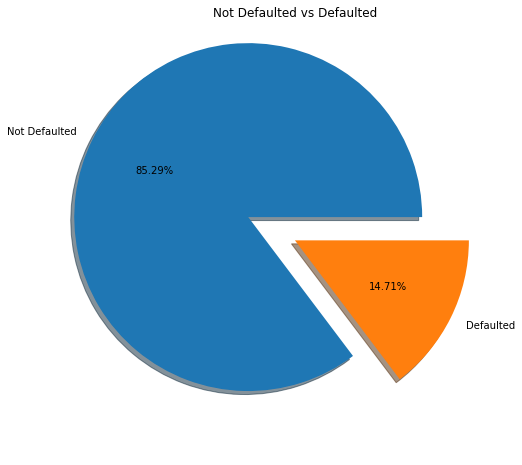

In [26]:
%matplotlib inline

# Showing the distribution of our target variable
plt.figure(figsize = (8,8))
plt.pie(
    x = df['LOAN_WAS_PAID_BACK'].value_counts(),
    labels = ['Not Defaulted','Defaulted'],
    autopct = '%1.2f%%',
    shadow = True,
    explode = (0.3,0)
)
plt.title('Not Defaulted vs Defaulted')
plt.show();

The chart shows that we are facing and imbalanced problem, which might need further processing later on during modelling

### Distribution of age

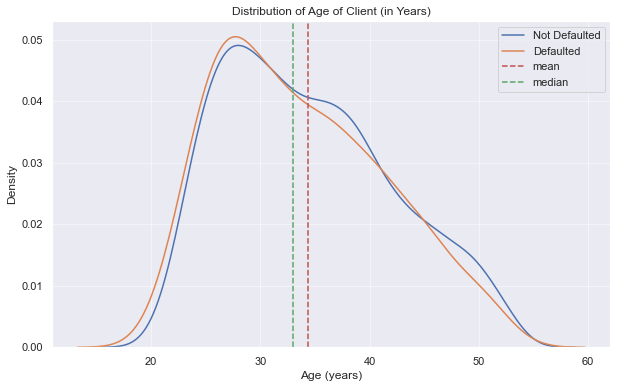

In [30]:
plt.figure(figsize=(10,6))
plt.grid(True, alpha=0.5)
sns.kdeplot(df.loc[df['LOAN_WAS_PAID_BACK'] == 1, 'AGE'] , label = 'Not Defaulted')
sns.kdeplot(df.loc[df['LOAN_WAS_PAID_BACK'] == 0, 'AGE'] ,  label = 'Defaulted')
plt.axvline(df.AGE.mean(), 0, 1, label = 'mean', color = 'r', ls = '--')
plt.axvline(df.AGE.median(), 0, 1, label = 'median', color = 'g', ls = '--')
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.legend()
plt.title('Distribution of Age of Client (in Years)');

Younger customer tend to default more compare to older customer

Male      1714
Female    1487
Name: GENDER, dtype: int64


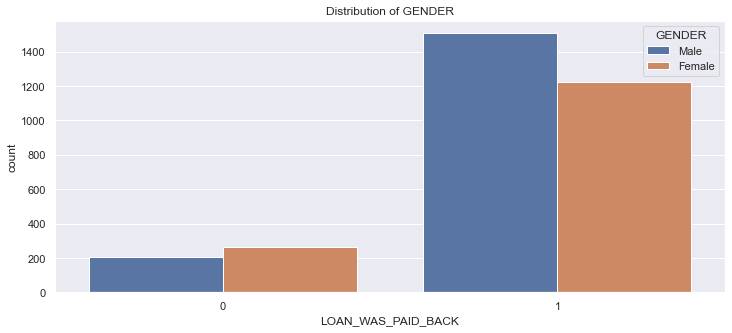

In [29]:
# visualize gender distribution related to target
print(df.GENDER.value_counts())

plt.figure(figsize=(12,5))
ax = sns.countplot(x="LOAN_WAS_PAID_BACK", hue="GENDER", data=df)
plt.title("Distribution of GENDER")
plt.show()

Male tend to pay back the loan more than female

## Initial Data Exploration

#### Load necessary function 

In [5]:
def check_data(df):
    """
        Function to get information of our dataframe, such as number of rows and features, 
        number of categorical and numerical features, and basic statistical information
        of the data
    """
    
    cat_th = 10
    car_th = 20
    
    # get categorical columns, including numeric but are categorize as categorical column
    cat_cols = df.select_dtypes(["object", "category"]).columns.tolist()
    num_but_cat = [col for col in df.select_dtypes(["float", "integer"]).columns if df[col].nunique() < cat_th]
    
    # categorical columns with high cardinality
    cat_but_car = [col for col in df.select_dtypes(["object", "category"]).columns if df[col].nunique() > car_th]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    
    # get numerical columns
    num_cols = df.select_dtypes(["float", "integer"]).columns
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    print("Dataframe shape : {}".format(df.shape))
    print("-------------------------------------------")
    print("Missing Values percentage : \n{} ".format(df.isna().sum()/len(df)))
    print("-------------------------------------------")
    print("Statistics of Numerical features : \n{}".format(df.describe()))
    print("-------------------------------------------")
    print("Number of categorical columns : \n{}".format(len(cat_cols)))
    print("-------------------------------------------")
    print("Number of numerical columns : \n{}".format(len(num_cols)))
    
    return cat_cols, cat_but_car, num_cols, num_but_cat
    
    

In [6]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = df.select_dtypes(["category", "object"]).columns.tolist()
    # categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

### A. Master Customer Data 

In [7]:
cat_cols_master, cat_but_car_master, num_cols_master, num_but_cat_master = check_data(master)

Dataframe shape : (6588, 10)
-------------------------------------------
Missing Values percentage : 
customer_id                 0.000000
AGE                         0.000000
INCOME                      0.000304
GENDER                      0.000000
EDUCATION                   0.000000
LOAN_PURPOSE                0.007438
APPLICATION_RECEIVE_TIME    0.000000
HAS_APPLIED_BEFORE          0.000000
HAS_INCOME_VERIFICATION     0.000000
LOAN_WAS_PAID_BACK          0.000000
dtype: float64 
-------------------------------------------
Statistics of Numerical features : 
        customer_id          AGE        INCOME  LOAN_WAS_PAID_BACK
count   6588.000000  6588.000000  6.586000e+03         6588.000000
mean   39801.079539    34.443989  8.019131e+06            0.853825
std     1922.288595     7.737636  6.582340e+06            0.353308
min    36493.000000    20.000000  0.000000e+00            0.000000
25%    38139.750000    28.000000  4.000000e+06            1.000000
50%    39786.500000    33.5000

In [8]:
# check missing value in income column
print(len(master[master['INCOME'].isna()]))
master[master['INCOME'].isna()]

2


,customer_id,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK
51,36544,38,NaN,Female,Diploma,Renovation,00:57:00,No,Yes,1
420,36913,42,NaN,Female,Bachelor Degree,Working Capital,11:28:00,Yes,Yes,1


In [9]:
# check missing value in the LOAN PURPOSE column
print(len(master[master['LOAN_PURPOSE'].isna()]))
master[master['LOAN_PURPOSE'].isna()]

49


,customer_id,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK
37,36530,39,12000000.0,Female,Bachelor Degree,NaN,22:07:00,No,Yes,1
237,36730,33,7000000.0,Male,Bachelor Degree,NaN,13:30:00,No,Yes,1
337,36830,44,7000000.0,Male,Bachelor Degree,NaN,11:48:00,No,Yes,1
390,36883,41,8000000.0,Male,Bachelor Degree,NaN,12:00:00,No,Yes,1
417,36910,25,0.0,Male,Diploma,NaN,07:48:00,No,Yes,1
481,36974,27,5000000.0,Male,High School,NaN,23:44:00,No,Yes,1
665,37158,37,3000000.0,Male,High School,NaN,17:41:00,No,Yes,1
955,37448,27,5000000.0,Female,High School,NaN,11:41:00,Yes,Yes,1
1344,37837,40,6000000.0,Male,High School,NaN,08:56:00,No,Yes,1
1469,37962,43,12000000.0,Male,Diploma,NaN,16:47:00,No,Yes,1


1. There are 2 rows without income data, which we can simply impute using median data later on
2. 49 rows with null values in Loan Purpose column. We can impute this as Other Loan
3. We can see that customer income are ranging from 0 to 1e8. We will assume income is in IDR, and this is the monthly income of each customer

In [14]:
# check unique values of each categorical features
for col in cat_cols_master:
    print(master[col].value_counts())
    print("")

Male      3538
Female    3050
Name: GENDER, dtype: int64

Bachelor Degree                  3448
High School                      1753
Diploma                          1150
Master's Degree/Post graduate     185
Other                              52
Name: EDUCATION, dtype: int64

Working Capital              2044
Renovation                   1812
Credit card                  1486
Electronic unsecured loan     221
Holiday                       197
Investment                    179
Bills                         174
Education                     153
Venture capital               119
Other                          84
Housing loan                   67
Car/Motorcycle                  3
Name: LOAN_PURPOSE, dtype: int64

No     4246
Yes    2342
Name: HAS_APPLIED_BEFORE, dtype: int64

Yes    6438
No      150
Name: HAS_INCOME_VERIFICATION, dtype: int64

1    5625
0     963
Name: LOAN_WAS_PAID_BACK, dtype: int64



In [15]:
# calculate percentage of top 3 categories in the LOAN_PURPOSE column
loan_list = master.LOAN_PURPOSE.value_counts()[:3]
sum(loan_list)/len(master)

0.8108682452944748

1. Almost equal number of male and female applicants
2. Loan purpose categorical feature has quite high cardinality, but looking at the number closely most loans (81%) fall into the top 3 categories which are working capital, renovation and credit card. Therefore we can group other categories into a single "Other Loan" category to reduce dimensionality when we try to encode this feature later

### B. Bureau Data 

In [16]:
cat_cols_br, cat_but_car_br, num_cols_br, num_but_cat_br = check_data(bureau)

Dataframe shape : (5268, 4)
-------------------------------------------
Missing Values percentage : 
customer_id             0.00000
LOANS_WITHOUT_DELAYS    0.00000
LOANS_WITH_DELAYS       0.00000
KNOWN_ASSETS            0.27164
dtype: float64 
-------------------------------------------
Statistics of Numerical features : 
        customer_id  LOANS_WITHOUT_DELAYS  LOANS_WITH_DELAYS  KNOWN_ASSETS
count   5268.000000           5268.000000        5268.000000  3.837000e+03
mean   39799.389142              1.650152           0.413250  1.287204e+07
std     1921.185055              0.826997           0.891211  1.259531e+07
min    36493.000000              1.000000           0.000000  0.000000e+00
25%    38138.750000              1.000000           0.000000  0.000000e+00
50%    39785.000000              1.000000           0.000000  1.000000e+07
75%    41452.250000              2.000000           0.000000  2.000000e+07
max    43184.000000              8.000000           3.000000  5.000000e+07


In [17]:
bureau[bureau['LOANS_WITHOUT_DELAYS'] == 0].shape[0]

0

In [18]:
# calculate percentage of rows in KNOWN_ASSETS column which are either empty or equal to 0
(bureau[bureau['KNOWN_ASSETS'] == 0].shape[0] + bureau[bureau['KNOWN_ASSETS'].isna()].shape[0])/len(bureau)

0.45861807137433563

1. First thing to notice is that the number of rows in bureau dataframe does not match with our master customer data. This could imply that group of customers have not had their bureau data available - either they might have never had any loan approved before applying to this particular bank, or there are errors during bureau data retrieval. Let us assume this happen because of the former reason
2. If we check number of customers with 0 LOANS_WITHOUT_DELAYS, there is no records of such customer, thus reinforcing our previous assumption that a group of customers are first time applicants.
3. About 45% of the KNOWN_ASSETS column are either 0 or null in values, which might not provide much information during modeling. However we are going to keep the column and impute null values later on.
4. We can create new features such as "delq_hist" as binary feature which identifies if a customer have previously had late payment in one of their loans, and "total_loan_count" as the number of loans that each customer had or have currently had.
5. We can also create a "bureau_flag" feature to identify if a customer has had bureau data available


### C. External Data 

In [19]:
cat_cols_ext, cat_but_car_ext, num_cols_ext, num_but_cat_ext = check_data(external)

Dataframe shape : (4581, 2)
-------------------------------------------
Missing Values percentage : 
customer_id    0.0
Score          0.0
dtype: float64 
-------------------------------------------
Statistics of Numerical features : 
        customer_id        Score
count   4581.000000  4581.000000
mean   39801.388561     0.784995
std     1908.912405     0.083611
min    36493.000000     0.500000
25%    38146.000000     0.760000
50%    39782.000000     0.790000
75%    41446.000000     0.840000
max    43182.000000     0.950000
-------------------------------------------
Number of categorical columns : 
0
-------------------------------------------
Number of numerical columns : 
2


Not all customer has external data available, however we are still going to use this feature with imputation later on

### D. Merge all Data

In [20]:
# merge master and bureau and external data
df = pd.merge(master, bureau, on='customer_id', how='left')
df = pd.merge(df, external, on='customer_id', how='left')
df.head()

,customer_id,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK,LOANS_WITHOUT_DELAYS,LOANS_WITH_DELAYS,KNOWN_ASSETS,Score
0,36493,40,10000000.0,Female,Diploma,Working Capital,09:07:00,No,Yes,1,3.0,3.0,40000000.0,0.77
1,36494,39,15000000.0,Female,Bachelor Degree,Other,15:15:00,No,Yes,1,3.0,0.0,20000000.0,0.93
2,36495,28,15000000.0,Male,Bachelor Degree,Renovation,07:13:00,No,Yes,1,NaN,NaN,NaN,NaN
3,36496,28,4000000.0,Male,Bachelor Degree,Renovation,12:05:00,Yes,Yes,1,2.0,1.0,0.0,0.78
4,36497,38,10000000.0,Male,Diploma,Renovation,14:35:00,Yes,Yes,0,1.0,0.0,40000000.0,0.81


## Exploratory Data Analysis 

EDA aims to understand what are the insights that can be concluded from the data. The foremost analysis is to see the distribution of our target variable. Then, we look for insights that can be derived from the data based, and hopefully can act as guidance when we do our modelling steps

In [21]:
# Showing the distribution of our target variable
plt.figure(figsize = (8,8))
plt.pie(
    x = df['LOAN_WAS_PAID_BACK'].value_counts(),
    labels = ['Not Defaulted','Defaulted'],
    autopct = '%1.2f%%',
    shadow = True,
    explode = (0.3,0)
)
plt.title('Not Defaulted vs Defaulted')
plt.show()

We can see most of our customers (~ 85%) managed to pay back their loan. However this can also mean there are slight class imbalance on our data, which are common in credit scoring cases

In [22]:
plt.figure(figsize=(10,6))
plt.grid(True, alpha=0.5)
sns.kdeplot(df.loc[df['LOAN_WAS_PAID_BACK'] == 1, 'AGE'] , label = 'Not Defaulted')
sns.kdeplot(df.loc[df['LOAN_WAS_PAID_BACK'] == 0, 'AGE'] ,  label = 'Defaulted')
plt.axvline(df.AGE.mean(), 0, 1, label = 'mean', color = 'r', ls = '--')
plt.axvline(df.AGE.median(), 0, 1, label = 'median', color = 'g', ls = '--')
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.legend()
plt.title('Distribution of Age of Client (in Years)');

Median age of our customers is about 34 years old, with distribution of age slightly skewed to the right. However there is only slight difference in which age affect customer's capability to pay back loans, with older customer tends to not default 

In [23]:
print(df.GENDER.value_counts())

plt.figure(figsize=(12,5))
ax = sns.countplot(x="LOAN_WAS_PAID_BACK", hue="GENDER", data=df)
plt.title("Distribution of GENDER")
plt.show()

Male      3538
Female    3050
Name: GENDER, dtype: int64


Most applicants are Male, with Female customers tend to default on ther payment more than their Male counterparts

In [24]:
plt.figure(figsize=(12,5))
ax = sns.countplot(hue="LOAN_WAS_PAID_BACK", x="EDUCATION", data=df, )
plt.title("Distribution of Education Status")
plt.show()

More customers pay back their loan compare to the number of default applicants consistently accross all Education Status.
However if we take a look at the proportion of default vs non default in each education status :

In [25]:
cek = df.LOAN_WAS_PAID_BACK.groupby(df.EDUCATION).value_counts(normalize=True).rename("counts").reset_index()
plt.figure(figsize=(12,5))
sns.barplot(x='EDUCATION', y='counts',  data = cek.loc[cek.LOAN_WAS_PAID_BACK == 1])
plt.ylabel("Percent")
plt.title("Percentage of Paying Customer for each Education Status")

Text(0.5, 1.0, 'Percentage of Paying Customer for each Education Status')

High school graduates applicants are slightly less adherent compare to other education status

In [26]:
cek = df.dropna(subset=['INCOME'])
cek['log_income'] = np.log10(df.INCOME)

plt.figure(figsize=(12,8))
sns.kdeplot(cek.loc[cek['LOAN_WAS_PAID_BACK'] == 1, 'log_income'] , label = 'Not Defaulted')
sns.kdeplot(cek.loc[cek['LOAN_WAS_PAID_BACK'] == 0, 'log_income'] , label = 'Defaulted')
plt.xlabel('log income')
plt.ylabel('Density')
plt.legend()
plt.title('Distribution of Log Income ');

Noticable trend is that higher income customers are more likely to pay back their loans 

In [27]:
plt.figure(figsize=(12,8))
ax = sns.countplot(hue="HAS_APPLIED_BEFORE", x="LOAN_WAS_PAID_BACK", data=df)
plt.title("Comparison of New vs Existing Customer ")
plt.show()

Most customers are first time loan applicant to the bank, however they are more likely to default than existing customers

In [28]:
plt.figure(figsize=(12,8))
sns.histplot(x = external.Score, stat='density')
sns.kdeplot(df.loc[df['LOAN_WAS_PAID_BACK'] == 0, 'Score'], label = 'default')
sns.kdeplot(df.loc[df['LOAN_WAS_PAID_BACK'] == 1, 'Score'], label = 'non-default')
plt.title("Distribution of External Score")
plt.legend()
print(np.mean(external.Score))

0.7849945426762716


Non default customers tend to have a higher external score compare to default customers

In [29]:
cor = df.drop('customer_id', axis=1).corr()
plt.figure(figsize=(12,6))
sns.heatmap(cor,cmap='Set1',annot=True)

<AxesSubplot:>

There are no features with high corellation based on the heatmap above. The only features with noticeable level of collinearity are INCOME and KNOWN_ASSETS. Therefore it is safe to assume we can use all the numerical features available for our model

## Start Modelling

### A. Feature selection and  engineering 

In [39]:
# FEATURE ENGINEER NEW COLUMNS
# create have_bureau column
df['have_bureau'] = np.where(df['LOANS_WITHOUT_DELAYS'].isna() , 0, 1)

# create delq_hist columns
df['delq_hist'] = np.where(df['LOANS_WITH_DELAYS'] == 0 , 0, 1)
df['delq_hist'] = np.where(df['LOANS_WITH_DELAYS'].isna(), 0, df.delq_hist)

# create total approved loans
df['total_loans'] = df['LOANS_WITHOUT_DELAYS'] + df['LOANS_WITH_DELAYS']
df['total_loans'] = np.where(df.total_loans.isna(), 0.0, df.total_loans)

# drop unnecessary columns
df_final = df.drop(['APPLICATION_RECEIVE_TIME', 'customer_id'], axis = 1)

# impute missing value in INCOME variable with its median value
df_final['INCOME'] = df_final['INCOME'].fillna(df_final['INCOME'].median())

df_final.head()

,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK,LOANS_WITHOUT_DELAYS,LOANS_WITH_DELAYS,KNOWN_ASSETS,Score,have_bureau,delq_hist,total_loans
0,40,10000000.0,Female,Diploma,Working Capital,No,Yes,1,3.0,3.0,40000000.0,0.77,1,1,6.0
1,39,15000000.0,Female,Bachelor Degree,Other,No,Yes,1,3.0,0.0,20000000.0,0.93,1,0,3.0
2,28,15000000.0,Male,Bachelor Degree,Renovation,No,Yes,1,NaN,NaN,NaN,NaN,0,0,0.0
3,28,4000000.0,Male,Bachelor Degree,Renovation,Yes,Yes,1,2.0,1.0,0.0,0.78,1,1,3.0
4,38,10000000.0,Male,Diploma,Renovation,Yes,Yes,0,1.0,0.0,40000000.0,0.81,1,0,1.0


In [87]:
df_final.dtypes

AGE                          int64
INCOME                     float64
GENDER                      object
EDUCATION                   object
LOAN_PURPOSE                object
HAS_APPLIED_BEFORE          object
HAS_INCOME_VERIFICATION     object
LOAN_WAS_PAID_BACK           int64
LOANS_WITHOUT_DELAYS       float64
LOANS_WITH_DELAYS          float64
KNOWN_ASSETS               float64
Score                      float64
have_bureau                  int32
delq_hist                    int32
total_loans                float64
dtype: object

In [40]:
# # binary encode GENDER, HAS_INCOME_VERIFICATION, and HAS_APPLIED_BEFORE columns
# df_final['GENDER'] = df_final['GENDER'].map({"Female":0, "Male":1})
# df_final['HAS_INCOME_VERIFICATION'] = df_final['HAS_INCOME_VERIFICATION'].map({"No":0, "Yes":1})
# df_final['HAS_APPLIED_BEFORE'] = df_final['HAS_APPLIED_BEFORE'].map({"No":0, "Yes":1})

# # Group LOAN PURPOSE other than Working Capital, Renovation and Credit Card as Other loan
# df_final['LOAN_PURPOSE'] = np.where(df_final.LOAN_PURPOSE.isin(['Working Capital', 'Renovation', 'Credit card']),
#                                    df_final.LOAN_PURPOSE, 'Other Loans')

# # One hot encode categorical variables
# cat_cols = ['EDUCATION', 'LOAN_PURPOSE']
# df_final, cat_cols = one_hot_encoder(df_final, nan_as_category=False)

# # impute missing value in INCOME variable with its median value
# df_final['INCOME'] = df_final['INCOME'].fillna(df_final['INCOME'].median())

# # transform INCOME and KNOWN ASSET to logarithmic scale
# df_final[['INCOME', 'KNOWN_ASSETS']] = np.log10(df_final[['INCOME', 'KNOWN_ASSETS']])
# df_final['KNOWN_ASSETS'] = np.where(df_final['KNOWN_ASSETS'] < 0, 0, df_final['KNOWN_ASSETS'])
# df_final['INCOME'] = np.where(df_final['INCOME'] < 0, 0, df_final['INCOME'])

In [41]:
# function to print out missing value in our data
def missing_values(data, plot=False):
    mst = pd.DataFrame(
        {"Num_Missing": data.isnull().sum(), "Missing_Ratio": data.isnull().sum()/data.shape[0]}).sort_values(
        "Num_Missing", ascending=False)
    mst["DataTypes"] = data[mst.index].dtypes.values
    mst = mst[mst.Num_Missing > 0].reset_index().rename({"index": "Feature"}, axis=1)

    print("Number of Variables include Missing Values:", mst.shape[0], "\n")

    if mst[mst.Missing_Ratio >= 0.5].shape[0] > 0:
        print("Full Missing Variables:", mst[mst.Missing_Ratio >= 0.5].Feature.tolist())

    if plot:
        plt.figure(figsize=(25, 8))
        p = sns.barplot(mst.Feature, mst.Missing_Ratio)
        for rotate in p.get_xticklabels():
            rotate.set_rotation(90)
        plt.show()

    print(mst, "\n")
    return mst

### B. Create Holdout (Testing) dataset

Before we move on further with our data preparation, it is important to first divide our data into training and holdout/testing dataset. This is to prevent the possibility of data leakage when we do imputation or other transformation to our data, and making sure all the necessary data transformation process are done only on our training data

In [111]:
# we are going to stratify our split to make sure equal proportion of each class
# are located in each train/test split
X_train, X_test, y_train, y_test = train_test_split(df_final.drop('LOAN_WAS_PAID_BACK', axis=1), 
                                                    df_final['LOAN_WAS_PAID_BACK'], 
                                                    test_size = 0.3,
                                                    random_state = 42,
                                                    stratify=df_final['LOAN_WAS_PAID_BACK'])

In [112]:
y_test.value_counts()/len(y_test)

1    0.853819
0    0.146181
Name: LOAN_WAS_PAID_BACK, dtype: float64

In [113]:
y_train.value_counts()/len(y_train)

1    0.853828
0    0.146172
Name: LOAN_WAS_PAID_BACK, dtype: float64

###  C. Feature engineering using WOE and IV

In [114]:
X_train.isna().sum()

AGE                           0
INCOME                        0
GENDER                        0
EDUCATION                     0
LOAN_PURPOSE                 36
HAS_APPLIED_BEFORE            0
HAS_INCOME_VERIFICATION       0
LOANS_WITHOUT_DELAYS        927
LOANS_WITH_DELAYS           927
KNOWN_ASSETS               1925
Score                      1407
have_bureau                   0
delq_hist                     0
total_loans                   0
dtype: int64

In [115]:
X_test.isna().sum()

AGE                          0
INCOME                       0
GENDER                       0
EDUCATION                    0
LOAN_PURPOSE                13
HAS_APPLIED_BEFORE           0
HAS_INCOME_VERIFICATION      0
LOANS_WITHOUT_DELAYS       393
LOANS_WITH_DELAYS          393
KNOWN_ASSETS               826
Score                      600
have_bureau                  0
delq_hist                    0
total_loans                  0
dtype: int64

In [116]:
# monotonic binning for numerical features on train data
from xverse.transformer import MonotonicBinning

clf = MonotonicBinning(max_bins = 5)
clf.fit(X_train, y_train)

print(clf.bins)
output_bins = clf.bins
clf.transform(X_train)

{'AGE': array([20., 30., 38., 54.]), 'INCOME': array([0.e+00, 5.e+06, 8.e+06, 1.e+08]), 'LOANS_WITHOUT_DELAYS': array([1., 2., 7.]), 'LOANS_WITH_DELAYS': array([ 0.,  1.,  2.,  3., nan]), 'KNOWN_ASSETS': array([       0., 10000000., 50000000.]), 'Score': array([0.5 , 0.77, 0.82, 0.95]), 'have_bureau': array([0., 1.]), 'delq_hist': array([0., 1.]), 'total_loans': array([0., 1., 2., 8.])}


,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOANS_WITHOUT_DELAYS,LOANS_WITH_DELAYS,KNOWN_ASSETS,Score,have_bureau,delq_hist,total_loans
5647,"(38.0, 54.0]","(-0.001, 5000000.0]",Male,Bachelor Degree,Credit card,Yes,Yes,NaN,NaN,NaN,"(0.77, 0.82]",0,0,"(-0.001, 1.0]"
2223,"(38.0, 54.0]","(5000000.0, 8000000.0]",Female,High School,Credit card,Yes,Yes,"(0.999, 2.0]",0.0,NaN,"(0.499, 0.77]",1,0,"(-0.001, 1.0]"
2929,"(19.999, 30.0]","(-0.001, 5000000.0]",Female,High School,Renovation,No,Yes,"(0.999, 2.0]",0.0,NaN,"(0.77, 0.82]",1,0,"(1.0, 2.0]"
559,"(19.999, 30.0]","(8000000.0, 100000000.0]",Male,Bachelor Degree,Working Capital,Yes,Yes,"(2.0, 7.0]",0.0,"(-0.001, 10000000.0]","(0.499, 0.77]",1,0,"(2.0, 8.0]"
3765,"(38.0, 54.0]","(-0.001, 5000000.0]",Male,Bachelor Degree,NaN,No,Yes,"(0.999, 2.0]",2.0,"(-0.001, 10000000.0]",NaN,1,1,"(2.0, 8.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2396,"(38.0, 54.0]","(8000000.0, 100000000.0]",Female,High School,Working Capital,No,Yes,"(0.999, 2.0]",0.0,"(-0.001, 10000000.0]","(0.499, 0.77]",1,0,"(1.0, 2.0]"
1462,"(19.999, 30.0]","(5000000.0, 8000000.0]",Female,Diploma,Bills,No,Yes,NaN,NaN,NaN,"(0.82, 0.95]",0,0,"(-0.001, 1.0]"
2302,"(19.999, 30.0]","(-0.001, 5000000.0]",Male,High School,Credit card,No,Yes,NaN,NaN,NaN,"(0.77, 0.82]",0,0,"(-0.001, 1.0]"
6307,"(38.0, 54.0]","(5000000.0, 8000000.0]",Female,High School,Working Capital,No,Yes,"(0.999, 2.0]",0.0,"(10000000.0, 50000000.0]",NaN,1,0,"(-0.001, 1.0]"


In [117]:
from xverse.transformer import WOE
woe_trans = WOE(treat_missing='separate')
woe_trans.fit(X_train, y_train)

WOE(mono_custom_binning={'AGE': array([20., 30., 38., 54.]),
                         'INCOME': array([0.e+00, 5.e+06, 8.e+06, 1.e+08]),
                         'KNOWN_ASSETS': array([       0., 10000000., 50000000.]),
                         'LOANS_WITHOUT_DELAYS': array([1., 2., 7.]),
                         'LOANS_WITH_DELAYS': array([ 0.,  1.,  2.,  3., nan]),
                         'Score': array([0.5 , 0.77, 0.82, 0.95]),
                         'delq_hist': array([0., 1.]),
                         'have_bureau': array([0., 1.]),
                         'total_loans': array([0....
                        Interval(0.82, 0.95, closed='right'): 0.7232039636807407,
                        'NA': 0.14174525587060166},
              'delq_hist': {0: -0.004818618324051432, 1: 0.023834661058486837},
              'have_bureau': {0: -0.05508751985028275, 1: 0.01420478160469477},
              'total_loans': {Interval(-0.001, 1.0, closed='right'): -0.12774699796305555,
             

In [118]:
woe_trans.woe_df

,Variable_Name,Category,Count,Event,Non_Event,Event_Rate,Non_Event_Rate,Event_Distribution,Non_Event_Distribution,WOE,Information_Value
0,AGE,"(19.999, 30.0]",1726,1442,284,0.835458,0.164542,0.366269,0.421365,-0.140132,0.013505
1,AGE,"(30.0, 38.0]",1509,1299,210,0.860835,0.139165,0.329947,0.311573,0.057298,0.013505
2,AGE,"(38.0, 54.0]",1376,1196,180,0.869186,0.130814,0.303785,0.267062,0.128837,0.013505
3,EDUCATION,Bachelor Degree,2432,2114,318,0.869243,0.130757,0.536957,0.471810,0.129342,0.087662
4,EDUCATION,Diploma,818,696,122,0.850856,0.149144,0.176784,0.181009,-0.023616,0.087662
5,EDUCATION,High School,1193,969,224,0.812238,0.187762,0.246126,0.332344,-0.300326,0.087662
6,EDUCATION,Master's Degree/Post graduate,127,124,3,0.976378,0.023622,0.031496,0.004451,1.956725,0.087662
7,EDUCATION,Other,41,34,7,0.829268,0.170732,0.008636,0.010386,-0.184494,0.087662
8,GENDER,Female,2130,1768,362,0.830047,0.169953,0.449073,0.537092,-0.178984,0.031076
9,GENDER,Male,2481,2169,312,0.874244,0.125756,0.550927,0.462908,0.174074,0.031076


In [119]:
iv = woe_trans.iv_df

# only take features with IV > 0.02
to_drop = list(iv.loc[iv.Information_Value < 0.02, 'Variable_Name'])
to_drop

['AGE', 'LOANS_WITH_DELAYS', 'have_bureau', 'delq_hist']

In [120]:
# transform X_train with WOE
X_train = woe_trans.transform(X_train)
X_train = X_train.drop(to_drop, axis = 1)
X_train.head()

,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOANS_WITHOUT_DELAYS,KNOWN_ASSETS,Score,total_loans
5647,-0.223224,0.174074,0.129342,0.278130,-0.333029,0.023719,-0.055088,-0.302226,0.042496,-0.127747
2223,-0.043008,-0.178984,-0.300326,0.278130,-0.333029,0.023719,-0.047560,-0.302226,-0.482525,-0.127747
2929,-0.223224,-0.178984,-0.300326,0.096697,0.223160,0.023719,-0.047560,-0.302226,0.042496,0.137915
559,0.482489,0.174074,0.129342,-0.392349,-0.333029,0.023719,0.446849,0.208068,-0.482525,0.195151
3765,-0.223224,0.174074,0.129342,1.790404,0.223160,0.023719,-0.047560,0.208068,0.141745,0.195151


In [122]:
# transform X_test using data from WOE
output_woe_bins = woe_trans.woe_bins
output_mono_bins = woe_trans.mono_custom_binning

woe_trans_test = WOE(woe_bins=output_woe_bins, mono_custom_binning=output_mono_bins)
X_test = woe_trans.transform(X_test)


In [124]:
# drop column from test data
X_test = X_test.drop(to_drop, axis = 1)

### C. Missing data imputation 

In [108]:
# missing_values(X_train)

We are going to impute missing values on LOANS_WITHOUT_DELAYS,LOANS_WITH_DELAYS and KNOWN_ASSETS column with 0. This is done based on our previous assumption, which states that customers with have empty value in all of those 3 columns do not have bureau data

In [109]:
# # impute LOANS_WITHOUT_DELAYS, LOAN_WITH_DELAYS, and KNOWN ASSETS with 0
# col = ['LOANS_WITHOUT_DELAYS', 'LOANS_WITH_DELAYS', 'KNOWN_ASSETS']

# X_train[col] = X_train[col].fillna(0)
# X_test[col] = X_test[col].fillna(0)

# # impute Score with median
# X_train = X_train.fillna(X_train.median())
# X_test = X_test.fillna(X_train.median())
# X_train.isna().sum()

### D. Train and Evaluate Models

In [125]:
def train_model(X_train, y_train, X_test, y_test, drop_col = None):
    if drop_col != None:
        X_train = X_train.drop(drop_col, axis=1)
        X_test = X_test.drop(drop_col, axis=1)
    else:
        pass
    
    # use balanced class_weight to make up for the class imbalance of target variable
    log_reg = LogisticRegression(random_state=5, class_weight='balanced')

    # scaled the numerical variable on training data
#     scale = StandardScaler()
#     X_train_res = scale.fit_transform(X_train)
#     X_test_res = scale.fit_transform(X_test)

    X_train_res = X_train.copy()
    X_test_res = X_test.copy()

    # Hyper Parameter Tuning using repeated stratified K fold cross validation
    parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
    search = GridSearchCV(log_reg, parameters, scoring='roc_auc', n_jobs=-1, cv=cv, verbose=2)
    search = search.fit(X_train_res, y_train)

    # evaluate training model
    log_reg_opt = LogisticRegression(C = search.best_estimator_.C, class_weight='balanced', random_state=5)
    clf_ = log_reg_opt.fit(X_train_res, y_train)
    n_scores = cross_val_score(log_reg_opt, X_train_res, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

    # report training model performance
    print("Average validation score : {:.3} with standard deviation : {:.3}".format(np.mean(n_scores), np.std(n_scores)))
    
    # get feature importance
    feat_importance = pd.DataFrame({'feat': X_train.columns,
              'coef': clf_.coef_.flatten().tolist()}).sort_values(by='coef', ascending=False)
    feat_df = pd.DataFrame(feat_importance)
    feat_df['odds'] = feat_df['coef'].apply(lambda x: np.exp(x))    
    
    
    # check on train data
    y_pred = clf_.predict(X_train_res)
    y_pred_proba = clf_.predict_proba(X_train_res)
    
    print("--------------------------------------------------")
    print("RESULT ON TRAINING DATA : ")
    print(classification_report(y_train, y_pred))
    print("ROC_AUC_TRAIN : {}".format(roc_auc_score(y_train, y_pred_proba[:,1])))
    
    # evaluate on test data
    y_pred = clf_.predict(X_test_res)
    y_pred_proba = clf_.predict_proba(X_test_res)
    
    print("--------------------------------------------------")
    print("RESULT ON TEST DATA : ")
    print(classification_report(y_test, y_pred))
    print("ROC_AUC_TRAIN : {}".format(roc_auc_score(y_test, y_pred_proba[:,1])))
        
    plt.figure(figsize=(16,8))
    plot_roc_curve(clf_, X_test_res,y_test)
    
    print("--------------------------------------------------")
    print("TEST DATA CONFUSION MATRIX AND ROC CURVE")
    plot_confusion_matrix(clf_, X_test_res, y_test)
    plt.show()
    
    return n_scores, clf_, feat_df

For baseline model we are going to use all available columns 

In [126]:
# baseline model
n , clf, features = train_model(X_train, y_train, X_test, y_test)
print("Feature Importance : \n")
features

Fitting 50 folds for each of 6 candidates, totalling 300 fits
Average validation score : 0.682 with standard deviation : 0.0365
--------------------------------------------------
RESULT ON TRAINING DATA : 
              precision    recall  f1-score   support

           0       0.23      0.66      0.34       674
           1       0.91      0.63      0.74      3937

    accuracy                           0.63      4611
   macro avg       0.57      0.64      0.54      4611
weighted avg       0.81      0.63      0.69      4611

ROC_AUC_TRAIN : 0.6886554856195766
--------------------------------------------------
RESULT ON TEST DATA : 
              precision    recall  f1-score   support

           0       0.20      0.59      0.30       289
           1       0.90      0.61      0.72      1688

    accuracy                           0.60      1977
   macro avg       0.55      0.60      0.51      1977
weighted avg       0.79      0.60      0.66      1977

ROC_AUC_TRAIN : 0.6349839698912

,feat,coef,odds
3,LOAN_PURPOSE,0.930988,2.537015
1,GENDER,0.872569,2.393050
8,Score,0.840107,2.316616
5,HAS_INCOME_VERIFICATION,0.754968,2.127543
6,LOANS_WITHOUT_DELAYS,0.649715,1.914994
4,HAS_APPLIED_BEFORE,0.596239,1.815279
2,EDUCATION,0.537490,1.711705
0,INCOME,0.511343,1.667530
7,KNOWN_ASSETS,0.489458,1.631432
9,total_loans,-0.007797,0.992233


1. Our baseline model score about 0.699 on training data and yield AUC of 0.653 in test data
2. Testing data accuracy is at about 63%, with Score as the most important feature
3. More importantly we need to look at the model specifity(True Negative Rate, TNR) when predicting class 0 (default) customers. As we want to reduce the amount of default customers, it is therefore more important for the model to be able to accurately predict default customer as default customer. For this baseline model, the TNR on test data is still low at 21%
4. For the next model, we are going to drop 5 least important feature based on our baseline model, and look at the results on test data

In [127]:
# drop less important features

n , clf, features = train_model(X_train, y_train, X_test, y_test, drop_col=list(features['feat'].tail(5)))
print("Feature Importance : \n")
features

Fitting 50 folds for each of 6 candidates, totalling 300 fits
Average validation score : 0.663 with standard deviation : 0.0381
--------------------------------------------------
RESULT ON TRAINING DATA : 
              precision    recall  f1-score   support

           0       0.21      0.64      0.32       674
           1       0.91      0.59      0.72      3937

    accuracy                           0.60      4611
   macro avg       0.56      0.62      0.52      4611
weighted avg       0.80      0.60      0.66      4611

ROC_AUC_TRAIN : 0.6657681178863841
--------------------------------------------------
RESULT ON TEST DATA : 
              precision    recall  f1-score   support

           0       0.20      0.59      0.29       289
           1       0.89      0.59      0.71      1688

    accuracy                           0.59      1977
   macro avg       0.54      0.59      0.50      1977
weighted avg       0.79      0.59      0.65      1977

ROC_AUC_TRAIN : 0.6018127142130

,feat,coef,odds
2,HAS_INCOME_VERIFICATION,1.013853,2.756201
1,LOAN_PURPOSE,0.988426,2.687001
4,Score,0.956733,2.603178
3,LOANS_WITHOUT_DELAYS,0.870661,2.388488
0,GENDER,0.859355,2.361637


1. This model perform worse than first model on both test and train data, with train AUC at 0.689 and test AUC at 0.644
2. The model also has lower TNR on test data (20%) compare to the first model
3. For our final model we are going to drop our engineered feature from before and only use original features

In [129]:
# drop engineered feature  

n , clf, features = train_model(X_train, y_train, X_test, y_test, drop_col=['total_loans'])
print("Feature Importance : \n")
features

Fitting 50 folds for each of 6 candidates, totalling 300 fits
Average validation score : 0.683 with standard deviation : 0.0362
--------------------------------------------------
RESULT ON TRAINING DATA : 
              precision    recall  f1-score   support

           0       0.23      0.66      0.34       674
           1       0.91      0.63      0.74      3937

    accuracy                           0.63      4611
   macro avg       0.57      0.64      0.54      4611
weighted avg       0.81      0.63      0.69      4611

ROC_AUC_TRAIN : 0.6886390924117161
--------------------------------------------------
RESULT ON TEST DATA : 
              precision    recall  f1-score   support

           0       0.20      0.59      0.30       289
           1       0.90      0.61      0.72      1688

    accuracy                           0.61      1977
   macro avg       0.55      0.60      0.51      1977
weighted avg       0.80      0.61      0.66      1977

ROC_AUC_TRAIN : 0.6349132488233

,feat,coef,odds
3,LOAN_PURPOSE,0.931025,2.537108
1,GENDER,0.872487,2.392854
8,Score,0.839976,2.316312
5,HAS_INCOME_VERIFICATION,0.754893,2.127384
6,LOANS_WITHOUT_DELAYS,0.647558,1.910869
4,HAS_APPLIED_BEFORE,0.596372,1.815520
2,EDUCATION,0.537589,1.711875
0,INCOME,0.511349,1.667539
7,KNOWN_ASSETS,0.488115,1.629242


1. This model score better compare to the 2nd model with 0.694 for train AUC and 0.66 for test AUC, slightly better than our baseline model
2. However the TNR is still lower than first model at 21%

Based on our modelling result, we are going to use our baseline model to calculate the probability of paying back loan for each customers. This is based on the fact that it has better train and validation AUC (from cross validation), as well as better True Negative Rate compare to other models

### E. Random Forest Classifier model 

As a side exercise we are going to test prediction using random forest model

In [169]:
from sklearn.ensemble import RandomForestClassifier
# Set baseline model
clf = RandomForestClassifier()

# Define evaluation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
# Define search space
space = dict()

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] #RF
max_depth.append(None) #RF
space['max_depth'] = max_depth # RF
space['min_samples_split'] = [2, 5, 10] # RF
space['min_samples_leaf'] = [1, 2, 4] # RF


# undersampling to accomodate for class imbalance
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_train_res, y_train_res = rus.fit_resample(X_train,y_train)


# scaled the numerical variable on training data
scale = StandardScaler()
X_train_res = scale.fit_transform(X_train_res)
X_test_res = scale.fit_transform(X_test)

# Define search
search = RandomizedSearchCV(clf, space, n_iter=20, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1, verbose=2)
# Execute search
result = search.fit(X_train_res, y_train_res)
# Summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best Score: 0.6560605613905779
Best Hyperparameters: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': None}


              precision    recall  f1-score   support

           0       0.20      0.62      0.31       289
           1       0.90      0.58      0.71      1688

    accuracy                           0.59      1977
   macro avg       0.55      0.60      0.51      1977
weighted avg       0.80      0.59      0.65      1977

0.6433721035110448


<Figure size 1152x576 with 0 Axes>

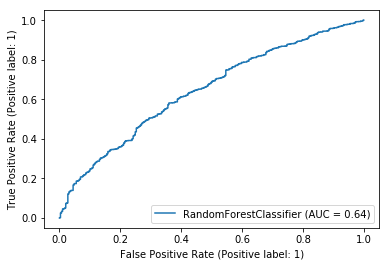

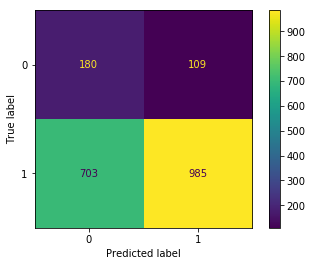

In [176]:
clf_final = RandomForestClassifier(min_samples_split=10, min_samples_leaf=4, max_depth=None).fit(X_train_res,y_train_res)

# check on test data
y_pred = clf_final.predict(X_test_res)
y_pred_proba = clf_final.predict_proba(X_test_res)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred_proba[:,1]))

plt.figure(figsize=(16,8))
plot_roc_curve(clf_final, X_test_res,y_test)
plot_confusion_matrix(clf_final, X_test_res, y_test)
plt.show()

## Calculate probability of loan payment for all customers 

In [192]:
# impute LOANS_WITHOUT_DELAYS, LOAN_WITH_DELAYS, and KNOWN ASSETS with 0
col = ['LOANS_WITHOUT_DELAYS', 'LOANS_WITH_DELAYS', 'KNOWN_ASSETS']

df_final[col] = df_final[col].fillna(0)

# impute Score with median
df_final2 = df_final.fillna(X_train.median()).drop("LOAN_WAS_PAID_BACK", axis=1)

# Scale all the features
scale = StandardScaler()
df_final2 = scale.fit_transform(df_final2)
df_final2.shape


(6588, 21)

Fitting 50 folds for each of 6 candidates, totalling 300 fits
Average validation score : 0.687 with standard deviation : 0.0296
--------------------------------------------------
RESULT ON TRAINING DATA : 
              precision    recall  f1-score   support

           0       0.23      0.63      0.34       674
           1       0.91      0.65      0.76      3937

    accuracy                           0.64      4611
   macro avg       0.57      0.64      0.55      4611
weighted avg       0.81      0.64      0.70      4611

ROC_AUC_TRAIN : 0.6987337283279909
--------------------------------------------------
RESULT ON TEST DATA : 
              precision    recall  f1-score   support

           0       0.22      0.57      0.31       289
           1       0.90      0.65      0.75      1688

    accuracy                           0.63      1977
   macro avg       0.56      0.61      0.53      1977
weighted avg       0.80      0.63      0.69      1977

ROC_AUC_TRAIN : 0.6526652618114

<Figure size 1152x576 with 0 Axes>

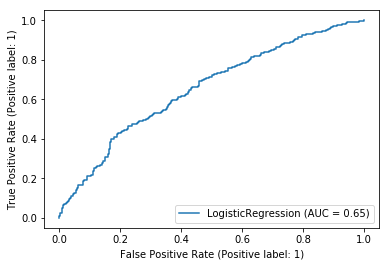

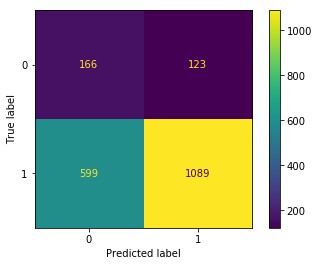

In [193]:
# use our baseline model to create prediction
# baseline model
n , clf, features = train_model(X_train, y_train, X_test, y_test)

In [195]:
prob_pred = clf.predict_proba(df_final2)[:,1]
prob_pred

array([0.40726851, 0.73716106, 0.63139872, ..., 0.77435865, 0.66165949,
       0.65816384])

In [212]:
# create prediction dataframe
df_final3 = pd.DataFrame([df.customer_id, prob_pred]).T
df_final3 = df_final3.rename(columns = {"Unnamed 0" : "proba"})
df_final3['customer_id'] = df_final3.customer_id.apply(int)
df_final3.head()

# save to csv
df_final3.to_csv("./Final_result_proba.csv")